# 載入資料集

In [17]:
!git clone https://github.com/Damian-Hsu/data_mining_lab2_phase3_data
!powershell Copy-Item "data_mining_lab2_phase3_data\private_competition" -Destination "private_competition" -Recurse
!powershell Remove-Item "data_mining_lab2_phase3_data" -Recurse -Force

Cloning into 'data_mining_lab2_phase3_data'...


# Preprocessing Steps

## 1. load data

In [1]:
import pandas as pd
import gc

final_posts = pd.read_json("./private_competition/final_posts.json")


In [2]:
final_posts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64171 entries, 0 to 64170
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   root    64171 non-null  object
dtypes: object(1)
memory usage: 501.5+ KB


In [3]:
posts_list = final_posts["root"].apply(lambda x: x["_source"]["post"])
posts_df = pd.json_normalize(posts_list)
posts_df.rename(columns={"post_id": "id"}, inplace=True)
posts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64171 entries, 0 to 64170
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        64171 non-null  object
 1   text      64171 non-null  object
 2   hashtags  64171 non-null  object
dtypes: object(3)
memory usage: 1.5+ MB


In [4]:
post_emotions = pd.read_csv("./private_competition/emotion.csv")
split = pd.read_csv("./private_competition/data_identification.csv")
posts_df = posts_df.merge(post_emotions, on = 'id', how='left')
posts_df = posts_df.merge(split, on = 'id', how='left')
del post_emotions,split,final_posts,posts_list
gc.collect()
posts_df.head(5)

,id,text,hashtags,emotion,split
0,0x61fc95,"We got the ranch, loaded our guns and sat up t...",[],NaN,test
1,0x35663e,I bet there is an army of married couples who ...,[],joy,train
2,0xc78afe,This could only end badly.,[],fear,train
3,0x90089c,My sister squeezed a lime in her milk when she...,[],joy,train
4,0xaba820,and that got my head bobbing a little bit.,[],NaN,test


## 2. Split train and test dataset

In [5]:
global_train_df = posts_df[posts_df["split"] == "train"]
global_test_df = posts_df[posts_df["split"] == "test"]
global_train_df = global_train_df.reset_index(drop=True)
global_test_df = global_test_df.reset_index(drop=True)
global_train_df.drop(["split"], axis = 1,  inplace=True)
global_test_df.drop(["split"], axis = 1, inplace=True)
print(global_train_df.info())
print(global_test_df.info())
del posts_df
gc.collect()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47890 entries, 0 to 47889
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        47890 non-null  object
 1   text      47890 non-null  object
 2   hashtags  47890 non-null  object
 3   emotion   47890 non-null  object
dtypes: object(4)
memory usage: 1.5+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16281 entries, 0 to 16280
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        16281 non-null  object
 1   text      16281 non-null  object
 2   hashtags  16281 non-null  object
 3   emotion   0 non-null      object
dtypes: object(4)
memory usage: 508.9+ KB
None


0

In [6]:
tags = []
for tag in global_train_df["hashtags"].to_list():
    tags.extend(tag)
unique_tags = list(set(tags))
unique_tags.sort()
len(unique_tags)

2801

In [7]:
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd

# Hashtags → One-hot encoding
mlb = MultiLabelBinarizer()
tag_df = pd.DataFrame(
    mlb.fit_transform(global_train_df["hashtags"]),
    columns=[f"tag_{t}" for t in mlb.classes_]
)

# 把 one-hot 特徵加入到原始 DataFrame
global_train_df = pd.concat([global_train_df, tag_df], axis=1)


# 2. Hashtags 合併到文本中
def merge_text_and_hashtags(row):
    hashtags = row["hashtags"]

    # 安全處理，有些資料可能不是 list
    if isinstance(hashtags, list):
        tags_str = " ".join([f"#{t}" for t in hashtags])
    else:
        tags_str = ""

    # 合併 text + hashtags
    return f"{row['text']} {tags_str}".strip()

global_train_df["text"] = global_train_df.apply(merge_text_and_hashtags, axis=1)
global_test_df["text"] = global_test_df.apply(merge_text_and_hashtags, axis=1)
# 查看結果
global_train_df.head()


,id,text,hashtags,emotion,tag_1,tag_10,tag_10golds24,tag_12,tag_120,tag_12years,...,tag_zion,tag_zodiacage,tag_zombie,tag_zombies,tag_zumba,tag_деньги,tag_الخفجي,tag_اليوم_الوطني,tag_सत,tag_アニメ
0,0x35663e,I bet there is an army of married couples who ...,[],joy,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0xc78afe,This could only end badly.,[],fear,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0x90089c,My sister squeezed a lime in her milk when she...,[],joy,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0x2ffb63,Thank you so much❤️,[],joy,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0x989146,Stinks because ive been in this program for a ...,[],joy,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


emotion
joy         23797
anger       10694
surprise     6281
sadness      3926
fear         2009
disgust      1183
Name: count, dtype: int64

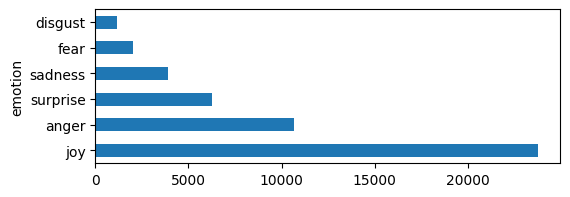

In [8]:
# 確保沒有na
global_train_df.value_counts("emotion").plot(kind = "barh",figsize=(6,2))
global_train_df.value_counts("emotion")

In [9]:
global_categories = global_train_df["emotion"].unique()

# Feature Engineering Steps

## 1. 建立分詞器

In [26]:
import sentencepiece as spm

# 先把語料丟到一個 txt 檔案

with open("./private_competition/corpus.txt", "w", encoding="utf-8") as f:
    for t in global_train_df["text"]:
        f.write(str(t).replace("\n", " ") + "\n")
    # 如果想加 test 的文字一起訓練，可以再加一輪：
    # for t in test_df["text"]:
    #     f.write(str(t).replace("\n", " ") + "\n")

# 訓練 SentencePiece 模型
spm.SentencePieceTrainer.train(
    input="./private_competition/corpus.txt",
    model_prefix="spm_bpe",
    vocab_size=8000,          # ★ 維度就在這裡控制：8000、12000、16000 自己選
    model_type="unigram",     # 或 "bpe"，兩個都可以
    character_coverage=0.9995, # 多語料建議高一點
)
# 會生成 spm_bpe.model, spm_bpe.vocab
del f, t
gc.collect()

0

In [27]:
# global_sp = spm.SentencePieceProcessor(model_file="spm_bpe.model")

# def sp_tokenizer(text):
#     # 回傳 subword list 就好
#     return global_sp.encode_as_pieces(str(text))


In [28]:
# === 1. Load original stopwords ===
with open("./private_competition/stopwords_english.txt", "r", encoding="utf-8") as f:
    stopwords = set([w.strip().lower() for w in f if w.strip()])


# === 2. Define whitelist (words to KEEP) ===
NEGATION_WHITELIST = {
    # Negation
    "not","no","never","none","nobody","nothing","nowhere",
    "neither","nor",
    "cannot","can't","cant",
    "don't","dont","doesn't","didn't",
    "won't","wouldn't","shouldn't","couldn't",
    "isn't","aren't","wasn't","weren't",
    "ain't",

    # Intensifiers
    "very","really","extremely","so","too","quite","highly",
    "totally","absolutely","completely","pretty","truly",
    "super","incredibly","immensely","deeply",

    # Downtoners
    "slightly","somewhat","barely","hardly","little",

    # Contrastive
    "but","however","yet","though","although","despite","still","nevertheless",

    # Question words
    "why","how","what","who","where","when",

    # Pronouns
    "i","me","my","mine","you","your","we","us","our","they","them","their",
}


# Normalize whitelist to match lowercase
WHITESET = set([w.lower() for w in NEGATION_WHITELIST])


# === 3. Remove whitelist from stopwords ===
cleaned_stopwords = {w for w in stopwords if w not in WHITESET}


# === 4. Save cleaned version ===
with open("./private_competition/stopwords_cleaned.txt", "w", encoding="utf-8") as f:
    for w in sorted(cleaned_stopwords):
        f.write(w + "\n")


print("Original stopwords:", len(stopwords))
print("Removed (whitelist matches):", len(stopwords - cleaned_stopwords))
print("Final stopwords:", len(cleaned_stopwords))
print("Saved to stopwords_cleaned.txt")
del WHITESET,  stopwords, NEGATION_WHITELIST, f, w

Original stopwords: 1223
Removed (whitelist matches): 60
Final stopwords: 1163
Saved to stopwords_cleaned.txt


## 2. TDM

In [29]:
from sklearn.feature_extraction.text import CountVectorizer
corpus = global_train_df['text'].tolist()
# global_count_vect = CountVectorizer( tokenizer=sp_tokenizer,token_pattern=None)
global_count_vect = CountVectorizer(lowercase=True)
global_count = global_count_vect.fit_transform(global_train_df['text'].tolist()) 
del corpus
gc.collect()

0

## 3. PAMI

In [48]:
# Initialize the CountVectorizer

X_counts = global_count_vect.fit_transform(global_train_df['text'])
words = global_count_vect.get_feature_names_out()

print(X_counts.shape)

category_dfs = {cat: subdf.copy() for cat, subdf in global_train_df.groupby('emotion', observed=False)}

# Function to create term-document frequency DataFrame for each category
def create_term_document_df(df):
    rows = df.index.to_numpy()
    X_sub = X_counts[rows, :]
    return pd.DataFrame(X_sub.toarray(), columns=words, index=rows)

# Create term-document frequency DataFrames for each category
tdm_dfs = {cat: create_term_document_df(subdf)
                          for cat, subdf in category_dfs.items()}
del X_counts, words, category_dfs
gc.collect()
tdm_dfs

(47890, 33893)


{'anger':        00  000  00001  0001  000k  000th  000x  00pm  00s  01  ...  アニメ  中国人  \
 5       0    0      0     0     0      0     0     0    0   0  ...    0    0   
 6       0    0      0     0     0      0     0     0    0   0  ...    0    0   
 9       0    0      0     0     0      0     0     0    0   0  ...    0    0   
 11      0    0      0     0     0      0     0     0    0   0  ...    0    0   
 14      0    0      0     0     0      0     0     0    0   0  ...    0    0   
 ...    ..  ...    ...   ...   ...    ...   ...   ...  ...  ..  ...  ...  ...   
 47855   0    0      0     0     0      0     0     0    0   0  ...    0    0   
 47866   0    0      0     0     0      0     0     0    0   0  ...    0    0   
 47878   0    0      0     0     0      0     0     0    0   0  ...    0    0   
 47886   0    0      0     0     0      0     0     0    0   0  ...    0    0   
 47887   0    0      0     0     0      0     0     0    0   0  ...    0    0   
 
        京n96s22  

In [49]:
from PAMI.extras.convert.DF2DB import DF2DB ,condition_operator, time, psutil
from typing import Union
from tqdm import tqdm
import os
import gc

class DF2DB_UTF8(DF2DB):
    def convert2TransactionalDatabase(self, oFile: str, condition: str, thresholdValue: Union[int, float]) -> None:
        """
        create transactional database and return oFileName
        :param oFile: file name or path to store database
        :type oFile: str
        :param condition: It is condition to judge the value
        :type condition: str
        :param thresholdValue: user defined threshold value
        :type thresholdValue: int or float
        """
        self._startTime = time.time()
        with open(oFile, 'w', encoding='utf-8' ) as f:
            if condition not in condition_operator:
                print('Condition error')
            else:
                for tid in self.tids:
                    transaction = [item for item in self.items if
                                   condition_operator[condition](self.inputDF.at[tid, item], thresholdValue)]
                    if len(transaction) > 1:
                        f.write(f'{transaction[0]}')
                        for item in transaction[1:]:
                            f.write(f'\t{item}')
                    elif len(transaction) == 1:
                        f.write(f'{transaction[0]}')
                    else:
                        continue
                    f.write('\n')
        process = psutil.Process(os.getpid())
        self._memoryUSS = process.memory_full_info().uss
        self._memoryRSS = process.memory_info().rss
        self._endTime  = time.time()
# Loop through the dictionary of term-document DataFrames
confirm_existence = True
for category in tqdm(global_categories):
    file_name = f'./private_competition/hw_td_freq_db_{category}.csv'
    if confirm_existence and os.path.exists(file_name):
        print(f'File {file_name} already exists. Skipping conversion.')
        continue
    # Create the DenseFormatDF object and convert to a transactional database
    obj = DF2DB_UTF8(tdm_dfs[category])
    obj.convert2TransactionalDatabase(file_name, '>=', 1)
    del obj
    gc.collect()
del confirm_existence,category,condition_operator, file_name, Union
gc.collect()

100%|██████████| 6/6 [1:38:26<00:00, 984.45s/it]   


0

In [50]:
from PAMI.extras.dbStats import TransactionalDatabase as tds
def transactional_database_explorer(category_name):
    print("="*30)
    print(f'Exploring category: {category_name}')
    obj = tds.TransactionalDatabase(f'./private_competition/hw_td_freq_db_{category_name}.csv')
    obj.run()
    num_transactions = obj.getDatabaseSize()
    # Calculate min support as n% of total transactions
    min_support = max(1, int(0.002 * num_transactions))  # Ensure at least 1
    print(f"min support : {min_support} for {num_transactions} transactions.")
    # obj.printStats()
    # obj.plotGraphs()
    del obj, num_transactions
    gc.collect()
    return min_support

In [51]:
min_supports = dict()
for category in tqdm(global_categories):
    min_supports[category] = transactional_database_explorer(category)
del category
gc.collect()

  0%|          | 0/6 [00:00<?, ?it/s]

Exploring category: joy
min support : 47 for 23790 transactions.


 17%|█▋        | 1/6 [00:00<00:03,  1.58it/s]

Exploring category: fear
min support : 4 for 2009 transactions.


 33%|███▎      | 2/6 [00:01<00:02,  1.70it/s]

Exploring category: anger
min support : 21 for 10693 transactions.


 50%|█████     | 3/6 [00:01<00:01,  1.71it/s]

Exploring category: surprise
min support : 12 for 6281 transactions.


 67%|██████▋   | 4/6 [00:02<00:01,  1.74it/s]

Exploring category: sadness
min support : 7 for 3925 transactions.


 83%|████████▎ | 5/6 [00:02<00:00,  1.76it/s]

Exploring category: disgust
min support : 2 for 1183 transactions.


100%|██████████| 6/6 [00:03<00:00,  1.75it/s]


0

In [52]:
from PAMI.frequentPattern.maximal import MaxFPGrowth  as alg
class MaxFPGrowthUTF8(alg.MaxFPGrowth):
    def save(self, outFile):
        """
        Complete set of frequent patterns will be loaded into an output file

        :param outFile: name of the output file
        :type outFile: csvfile
        """
        self._oFile = outFile
        with open(self._oFile, 'w+', encoding='utf-8') as writer:
            for x, y in self._finalPatterns.items():
                s1 = x.strip() + ":" + str(y)
                writer.write(f"{s1}\n")

def frequent_patterm_mining_FPGrowth(category_name, minSup=2):

    obj = MaxFPGrowthUTF8(iFile=f'./private_competition/hw_td_freq_db_{category_name}.csv', minSup=minSup)
    obj.mine()
    frequentPatterns= obj.getPatternsAsDataFrame()
    print('Total No of patterns: ' + str(len(frequentPatterns))) #print the total number of patterns
    print('Runtime: ' + str(obj.getRuntime())) #measure the runtime
    obj.save(f'./private_competition/freq_patterns_{category_name}_minSup{minSup}.txt') #save the patterns
    print(frequentPatterns.head(30))
    return frequentPatterns


In [53]:
patterns_dfs = []
for cat, minSup in tqdm(min_supports.items()):
    patterns_dfs.append(frequent_patterm_mining_FPGrowth(cat, minSup=minSup))
del minSup,cat
gc.collect()

 17%|█▋        | 1/6 [00:01<00:07,  1.49s/it]

Maximal Frequent patterns were generated successfully using MaxFp-Growth algorithm 
Total No of patterns: 5395
Runtime: 1.2114951610565186
    Patterns  Support
0    mother        47
1    listen        47
2   country        47
3     short        47
4   laughed        47
5      info        47
6      cold        47
7       met        47
8     posts        48
9      lots        48
10  minutes        48
11    gives        48
12   posted        48
13    issue        48
14    under        48
15      hug        48
16    phone        48
17  enjoyed        48
18    reply        48
19    helps        49
20     body        49
21     fast        49
22    buddy        50
23  smiling        50
24    using        50
25  happens        50
26    share        50
27     fans        50
28      cat        50
29  outside        50


 33%|███▎      | 2/6 [00:02<00:04,  1.07s/it]

Maximal Frequent patterns were generated successfully using MaxFp-Growth algorithm 
Total No of patterns: 9564
Runtime: 0.4660193920135498
                  Patterns  Support
0                  settle         4
1               concerned         4
2                   agent         4
3                    blue         4
4               up waking         4
5                    slow         4
6                   girls         4
7                  forced         4
8               for types         4
9                    call         4
10                  fears         4
11                  twice         4
12  the to and of heading         4
13                     dr         4
14             to of sort         4
15               emotions         4
16                clearly         4
17                 eating         4
18           my afternoon         4
19                 played         4
20             my muscles         4
21                  loves         4
22                 spread        

 50%|█████     | 3/6 [00:04<00:04,  1.37s/it]

Maximal Frequent patterns were generated successfully using MaxFp-Growth algorithm 
Total No of patterns: 7839
Runtime: 1.4623825550079346
        Patterns  Support
0          quit        21
1        forgot        21
2          rich        21
3   to supposed        21
4      official        21
5       workers        21
6        single        21
7         legal        21
8         nasty        21
9       outside        21
10      leaving        21
11         walk        21
12        tired        21
13      dumbass        21
14      telling        21
15       grudge        21
16        stuck        21
17      justice        21
18         meme        21
19          bet        21
20     complain        21
21          red        21
22         none        21
23          per        21
24    character        21
25       looked        21
26         hair        21
27           tv        21
28       months        21
29      removed        21


 67%|██████▋   | 4/6 [00:04<00:02,  1.14s/it]

Maximal Frequent patterns were generated successfully using MaxFp-Growth algorithm 
Total No of patterns: 7138
Runtime: 0.519390344619751
       Patterns  Support
0     straight        12
1      college        12
2          cut        12
3         dead        12
4         hair        12
5      telling        12
6          due        12
7         till        12
8       nobody        12
9         stay        12
10      scared        12
11         tbh        12
12        beat        12
13     support        12
14    favorite        12
15          30        12
16       clear        12
17     brother        12
18      asking        12
19         eye        12
20  completely        12
21     of sort        12
22       media        12
23   extremely        12
24  government        12
25      middle        12
26        body        12
27      notice        12
28         mad        12
29     himself        12


 83%|████████▎ | 5/6 [00:05<00:00,  1.01it/s]

Maximal Frequent patterns were generated successfully using MaxFp-Growth algorithm 
Total No of patterns: 8874
Runtime: 0.45342421531677246
       Patterns  Support
0       buying         7
1      forgive         7
2         grow         7
3      control         7
4       mother         7
5          mad         7
6    otherwise         7
7       fought         7
8   themselves         7
9           25         7
10     episode         7
11      middle         7
12         smh         7
13    somebody         7
14    slightly         7
15   ignorance         7
16        near         7
17      anyway         7
18   obviously         7
19     misread         7
20        fell         7
21        goes         7
22          12         7
23       drugs         7
24         fit         7
25      babies         7
26        haha         7
27    breaking         7
28      attack         7
29    coaching         7


100%|██████████| 6/6 [00:06<00:00,  1.03s/it]

Maximal Frequent patterns were generated successfully using MaxFp-Growth algorithm 
Total No of patterns: 9622
Runtime: 0.4351541996002197
                  Patterns  Support
0       the on icing cake         2
1                    glee         2
2              is smoking         2
3              in writing         2
4   the that like fingers         2
5        about staggering         2
6             about china         2
7                    nsfw         2
8           the is abuses         2
9                  rotten         2
10     and was repeatedly         2
11      to his supporters         2
12        the for fishing         2
13                the bus         2
14                it test         2
15            to it green         2
16                to code         2
17              his tired         2
18                 to rat         2
19                himself         2
20           go hopefully         2
21               programs         2
22            and covered        

45397

In [54]:
import pandas as pd

# Identify patterns that appear in more than one category
# Count how many times each pattern appears across all dataframes
pattern_counts = {}
for df in patterns_dfs:
    for pattern in df['Patterns']:
        if pattern not in pattern_counts:
            pattern_counts[pattern] = 1
        else:
            pattern_counts[pattern] += 1

# Filter out patterns that appear in more than one dataframe
unique_patterns = {pattern for pattern, count in pattern_counts.items() if count == 1}
# Calculate the total number of patterns across all categories
total_patterns_count = sum(len(df) for df in patterns_dfs)
# Calculate how many patterns were discarded
discarded_patterns_count = total_patterns_count - len(unique_patterns)

# For each category, filter the patterns to keep only the unique ones
filtered_dfs = []
for df in patterns_dfs:
    filtered_df = df[df['Patterns'].isin(unique_patterns)]
    filtered_dfs.append(filtered_df)

# Merge the filtered dataframes into a final dataframe
final_pattern_df = pd.concat(filtered_dfs, ignore_index=True)

# Sort by support
final_pattern_df = final_pattern_df.sort_values(by='Support', ascending=False)

# Display the final result
print(final_pattern_df)
# Print the number of discarded patterns
print(f"Number of patterns discarded: {discarded_patterns_count}")
del pattern_counts,unique_patterns,patterns_dfs,filtered_dfs,total_patterns_count,discarded_patterns_count, df
gc.collect()

                  Patterns  Support
1370        the to it and       165
915             the to at       158
1342        the to and of       155
911             the of at       148
594              that too       147
...                    ...      ...
17610          it youtube         2
25591        in name just         2
25592     to it name just         2
25593  to it in this just         2
25626      to and it name         2

[25691 rows x 2 columns]
Number of patterns discarded: 22741


0

In [55]:
import pandas as pd
from tqdm import tqdm

# Convert 'text' column into term-document matrix using CountVectorizer
terms = global_count_vect.get_feature_names_out()  # Original terms in the vocabulary

# Tokenize the sentences into sets of unique words
global_train_df['tokenized_text'] = global_train_df['text'].str.split().apply(set)

# Initialize the pattern matrix
global_pattern_matrix = pd.DataFrame(0, index=global_train_df.index, columns=final_pattern_df['Patterns'])

# Iterate over each pattern and check if all words in the pattern are present in the tokenized sentence
for pattern in tqdm(final_pattern_df['Patterns']):
    pattern_words = set(pattern.split())  # Tokenize pattern into words
    global_pattern_matrix[pattern] = global_train_df['tokenized_text'].apply(lambda x: 1 if pattern_words.issubset(x) else 0)

del terms, pattern, pattern_words
gc.collect()

100%|██████████| 25691/25691 [06:59<00:00, 61.31it/s]


14

## 4. TF-IDF

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = global_train_df['text'].tolist()
global_tfidf_vect = TfidfVectorizer()
global_tfidf = global_tfidf_vect.fit_transform(corpus) 
global_tfidf_vect.get_feature_names_out()
del corpus
gc.collect()

0

## 5. word embedding

In [11]:
from sentence_transformers import SentenceTransformer
import torch

In [12]:
# 自動偵測 GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)
model = SentenceTransformer(
    "intfloat/multilingual-e5-large",
    device=device)


Using device: cuda


In [13]:
corpus = global_train_df['text'].tolist()

embeddings_train = model.encode(
    corpus,
    normalize_embeddings=True,
    batch_size=16,
    show_progress_bar=True
)


Batches:   0%|          | 0/2994 [00:00<?, ?it/s]

In [14]:
test_texts = global_test_df["text"].tolist()

embeddings_test = model.encode(
    test_texts,
    normalize_embeddings=True,
    batch_size=16,
    show_progress_bar=True
)

Batches:   0%|          | 0/1018 [00:00<?, ?it/s]

In [15]:
import numpy as np
embeddings_train = np.array(embeddings_train)
print(embeddings_train.shape)


(47890, 1024)


# Modeling Step

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import classification_report, accuracy_score, f1_score

In [17]:
df_train_y = global_train_df[["emotion"]].copy()
df_train_y["label"] = df_train_y["emotion"].astype('category').cat.codes
mapping_cat = dict(enumerate(df_train_y["emotion"].astype('category').cat.categories))
# Convert the numerical category labels to text labels
target_names = [mapping_cat[label] for label in sorted(mapping_cat.keys())]
target_names

['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise']

## Modeling ComplementNB

In [37]:
def train_complement_nb(
    df_train_X: pd.DataFrame,
    df_train_y: pd.DataFrame,
    target_names: list
) -> ComplementNB:
    def _p(*args):
        """Helper function to print messages with a specific prefix."""
        msg = " ".join(str(a) for a in args)
        print(f"[complement nb] {msg}")
    # Split the data into training and testing sets (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(df_train_X,
                                                        df_train_y['label'].values,
                                                        test_size=0.2,
                                                        random_state=42)
    nb_classifier = ComplementNB()
    nb_classifier.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = nb_classifier.predict(X_test)

    # Evaluate the classifier
    _p("Accuracy:", accuracy_score(y_test, y_pred))
    _p("F1 Score:", f1_score(y_test, y_pred, average='weighted'))
    _p("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=target_names, digits=4))
    del X_train, X_test, y_train, y_test, y_pred
    gc.collect()
    return nb_classifier

### 1. TDM

In [38]:
df_train_X = global_count
train_complement_nb(
    df_train_X=df_train_X,
    df_train_y=df_train_y,
    target_names=target_names
)

[complement nb] Accuracy: 0.5759031112967217
[complement nb] F1 Score: 0.574310749041257
[complement nb] 
Classification Report:
               precision    recall  f1-score   support

       anger     0.5126    0.5232    0.5178      2135
     disgust     0.1042    0.1227    0.1127       220
        fear     0.3108    0.4408    0.3646       397
         joy     0.7270    0.7373    0.7321      4796
     sadness     0.3620    0.2721    0.3107       757
    surprise     0.3977    0.3574    0.3765      1273

    accuracy                         0.5759      9578
   macro avg     0.4024    0.4089    0.4024      9578
weighted avg     0.5750    0.5759    0.5743      9578



,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None
,norm,False


### 2. pattern matrix

In [ ]:
df_train_X = global_pattern_matrix
train_complement_nb(
    df_train_X=df_train_X,
    df_train_y=df_train_y,
    target_names=target_names
)


[complement nb] Accuracy: 0.4264982250991856
[complement nb] F1 Score: 0.4390961929230297
[complement nb] 
Classification Report:
               precision    recall  f1-score   support

       anger     0.3026    0.5208    0.3828      2135
     disgust     0.3030    0.3182    0.3104       220
        fear     0.2234    0.3703    0.2787       397
         joy     0.6773    0.4675    0.5532      4796
     sadness     0.2739    0.2048    0.2343       757
    surprise     0.3155    0.2820    0.2978      1273

    accuracy                         0.4265      9578
   macro avg     0.3493    0.3606    0.3429      9578
weighted avg     0.4864    0.4265    0.4391      9578



,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None
,norm,False


### 3. TF-IDF

In [39]:
df_train_X = pd.DataFrame(global_tfidf.toarray(), columns=global_tfidf_vect.get_feature_names_out())
train_complement_nb(
    df_train_X=df_train_X,
    df_train_y=df_train_y,
    target_names=target_names
)

[complement nb] Accuracy: 0.5705784088536229
[complement nb] F1 Score: 0.5480863052461322
[complement nb] 
Classification Report:
               precision    recall  f1-score   support

       anger     0.5390    0.4656    0.4996      2135
     disgust     0.0760    0.0909    0.0828       220
        fear     0.3371    0.3728    0.3541       397
         joy     0.6544    0.8071    0.7228      4796
     sadness     0.3568    0.2008    0.2570       757
    surprise     0.4052    0.2200    0.2851      1273

    accuracy                         0.5706      9578
   macro avg     0.3948    0.3595    0.3669      9578
weighted avg     0.5456    0.5706    0.5481      9578



,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None
,norm,False


### 4. embedding

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_non_negative = scaler.fit_transform(embeddings_train)

train_complement_nb(
    df_train_X=X_non_negative,
    df_train_y=df_train_y,
    target_names=target_names
)


[complement nb] Accuracy: 0.596993109208603
[complement nb] F1 Score: 0.5760719543334126
[complement nb] 
Classification Report:
               precision    recall  f1-score   support

       anger     0.4362    0.7480    0.5511      2135
     disgust     0.0000    0.0000    0.0000       220
        fear     0.4232    0.2846    0.3404       397
         joy     0.7584    0.7364    0.7473      4796
     sadness     0.5000    0.1334    0.2106       757
    surprise     0.4741    0.2946    0.3634      1273

    accuracy                         0.5970      9578
   macro avg     0.4320    0.3662    0.3688      9578
weighted avg     0.5971    0.5970    0.5761      9578



d:\DataMiningLab\DM2025-Lab2-Exercise\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\DataMiningLab\DM2025-Lab2-Exercise\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\DataMiningLab\DM2025-Lab2-Exercise\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None
,norm,False


### merge pattern

In [65]:
from scipy.sparse import csr_matrix, hstack

# 1. 將 pattern DataFrame 轉為 sparse
pattern_sparse = csr_matrix(global_pattern_matrix.values)

# 2. 橫向合併兩個 sparse matrix
X_augmented = hstack([global_count, pattern_sparse], format="csr")

# 這時 X_augmented 就是 (n_samples, n_features_total) 的 sparse matrix
print(X_augmented.shape)

(47890, 59584)


In [66]:
df_train_X = X_augmented
train_complement_nb(
    df_train_X=df_train_X,
    df_train_y=df_train_y,
    target_names=target_names
)

[complement nb] Accuracy: 0.5774692002505742
[complement nb] F1 Score: 0.5767141733857178
[complement nb] 
Classification Report:
               precision    recall  f1-score   support

       anger     0.5148    0.5148    0.5148      2135
     disgust     0.2044    0.2545    0.2267       220
        fear     0.2916    0.4635    0.3580       397
         joy     0.7257    0.7331    0.7294      4796
     sadness     0.3978    0.2827    0.3305       757
    surprise     0.4000    0.3629    0.3806      1273

    accuracy                         0.5775      9578
   macro avg     0.4224    0.4353    0.4233      9578
weighted avg     0.5795    0.5775    0.5767      9578



,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None
,norm,False


In [67]:
# 1. 將 pattern DataFrame 轉為 sparse
pattern_sparse = csr_matrix(global_pattern_matrix.values)

# 2. 橫向合併兩個 sparse matrix
X_augmented = hstack([global_count, pattern_sparse, global_tfidf], format="csr")

# 這時 X_augmented 就是 (n_samples, n_features_total) 的 sparse matrix
print(X_augmented.shape)

(47890, 93477)


In [68]:
df_train_X = X_augmented
train_complement_nb(
    df_train_X=df_train_X,
    df_train_y=df_train_y,
    target_names=target_names
)

[complement nb] Accuracy: 0.5803925662977657
[complement nb] F1 Score: 0.5779196080635542
[complement nb] 
Classification Report:
               precision    recall  f1-score   support

       anger     0.5180    0.5110    0.5145      2135
     disgust     0.1875    0.2455    0.2126       220
        fear     0.3053    0.4660    0.3689       397
         joy     0.7224    0.7446    0.7333      4796
     sadness     0.3895    0.2748    0.3222       757
    surprise     0.4087    0.3535    0.3791      1273

    accuracy                         0.5804      9578
   macro avg     0.4219    0.4325    0.4218      9578
weighted avg     0.5793    0.5804    0.5779      9578



,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None
,norm,False


## xgboost

In [41]:
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
def train_xgboost(
    df_train_X: pd.DataFrame,
    df_train_y: pd.DataFrame,
    target_names: list,
    X_scaled: bool = False
) -> XGBClassifier:
    def _p(*args):
        """Helper function to print messages with a specific prefix."""
        msg = " ".join(str(a) for a in args)
        print(f"[xgboost] {msg}")
    # Split the data into training and testing sets (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(df_train_X,
                                                        df_train_y['label'].values,
                                                        test_size=0.2,
                                                        random_state=42)
    xgb_classifier = XGBClassifier(
                                    n_estimators=200,
                                    max_depth=4,
                                    learning_rate=0.16,
                                    objective='multi:softmax',   # 如果是多分類
                                    eval_metric='mlogloss'
                                )
    if X_scaled:
        X_scaled = StandardScaler()
        X_train = X_scaled.fit_transform(X_train)
        X_test = X_scaled.transform(X_test)
    xgb_classifier.fit(X_train,
                       y_train,
                    #    early_stopping_rounds=50,
                       eval_set=[(X_test, y_test)],
                       verbose=True)

    # Make predictions on the test set
    y_pred = xgb_classifier.predict(X_test)

    # Evaluate the classifier
    _p("Accuracy:", accuracy_score(y_test, y_pred))
    _p("F1 Score:", f1_score(y_test, y_pred, average='weighted'))
    _p("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=target_names, digits=4))
    del X_train, X_test, y_train, y_test, y_pred
    gc.collect()
    return xgb_classifier

### 1. TDM

In [42]:
train_xgboost(
    df_train_X=global_count.toarray(),
    df_train_y=df_train_y,
    target_names=target_names,
    X_scaled = True
)

[0]	validation_0-mlogloss:1.57642
[1]	validation_0-mlogloss:1.52112
[2]	validation_0-mlogloss:1.47677
[3]	validation_0-mlogloss:1.43928
[4]	validation_0-mlogloss:1.40918
[5]	validation_0-mlogloss:1.38287
[6]	validation_0-mlogloss:1.36139
[7]	validation_0-mlogloss:1.34271
[8]	validation_0-mlogloss:1.32649
[9]	validation_0-mlogloss:1.31264
[10]	validation_0-mlogloss:1.30032
[11]	validation_0-mlogloss:1.28979
[12]	validation_0-mlogloss:1.28059
[13]	validation_0-mlogloss:1.27207
[14]	validation_0-mlogloss:1.26419
[15]	validation_0-mlogloss:1.25729
[16]	validation_0-mlogloss:1.25123
[17]	validation_0-mlogloss:1.24524
[18]	validation_0-mlogloss:1.23972
[19]	validation_0-mlogloss:1.23484
[20]	validation_0-mlogloss:1.23087
[21]	validation_0-mlogloss:1.22686
[22]	validation_0-mlogloss:1.22292
[23]	validation_0-mlogloss:1.21937
[24]	validation_0-mlogloss:1.21588
[25]	validation_0-mlogloss:1.21250
[26]	validation_0-mlogloss:1.20948
[27]	validation_0-mlogloss:1.20666
[28]	validation_0-mlogloss:1.2

,objective,'multi:softmax'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


### 2. TF-IDF

In [43]:
train_xgboost(
    df_train_X=global_tfidf.toarray(),
    df_train_y=df_train_y,
    target_names=target_names,
    X_scaled = True
)

[0]	validation_0-mlogloss:1.57587
[1]	validation_0-mlogloss:1.51960
[2]	validation_0-mlogloss:1.47481
[3]	validation_0-mlogloss:1.43763
[4]	validation_0-mlogloss:1.40702
[5]	validation_0-mlogloss:1.38089
[6]	validation_0-mlogloss:1.35908
[7]	validation_0-mlogloss:1.33974
[8]	validation_0-mlogloss:1.32416
[9]	validation_0-mlogloss:1.30999
[10]	validation_0-mlogloss:1.29747
[11]	validation_0-mlogloss:1.28679
[12]	validation_0-mlogloss:1.27719
[13]	validation_0-mlogloss:1.26844
[14]	validation_0-mlogloss:1.26095
[15]	validation_0-mlogloss:1.25378
[16]	validation_0-mlogloss:1.24750
[17]	validation_0-mlogloss:1.24186
[18]	validation_0-mlogloss:1.23643
[19]	validation_0-mlogloss:1.23144
[20]	validation_0-mlogloss:1.22699
[21]	validation_0-mlogloss:1.22254
[22]	validation_0-mlogloss:1.21849
[23]	validation_0-mlogloss:1.21535
[24]	validation_0-mlogloss:1.21236
[25]	validation_0-mlogloss:1.20898
[26]	validation_0-mlogloss:1.20610
[27]	validation_0-mlogloss:1.20322
[28]	validation_0-mlogloss:1.1

,objective,'multi:softmax'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


### 3. embedding

In [ ]:
train_xgboost(
    df_train_X=embeddings_train,
    df_train_y=df_train_y,
    target_names=target_names,
    X_scaled = True
)

[0]	validation_0-mlogloss:1.56574
[1]	validation_0-mlogloss:1.50202
[2]	validation_0-mlogloss:1.44986
[3]	validation_0-mlogloss:1.40658
[4]	validation_0-mlogloss:1.36987
[5]	validation_0-mlogloss:1.33830
[6]	validation_0-mlogloss:1.31118
[7]	validation_0-mlogloss:1.28740
[8]	validation_0-mlogloss:1.26708
[9]	validation_0-mlogloss:1.24873
[10]	validation_0-mlogloss:1.23276
[11]	validation_0-mlogloss:1.21864
[12]	validation_0-mlogloss:1.20547
[13]	validation_0-mlogloss:1.19320
[14]	validation_0-mlogloss:1.18270
[15]	validation_0-mlogloss:1.17335
[16]	validation_0-mlogloss:1.16442
[17]	validation_0-mlogloss:1.15638
[18]	validation_0-mlogloss:1.14902
[19]	validation_0-mlogloss:1.14139
[20]	validation_0-mlogloss:1.13481
[21]	validation_0-mlogloss:1.12890
[22]	validation_0-mlogloss:1.12274
[23]	validation_0-mlogloss:1.11747
[24]	validation_0-mlogloss:1.11287
[25]	validation_0-mlogloss:1.10803
[26]	validation_0-mlogloss:1.10343
[27]	validation_0-mlogloss:1.09916
[28]	validation_0-mlogloss:1.0

,objective,'multi:softmax'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


## SVM

In [18]:
from sklearn.svm import LinearSVC
X_train, X_test, y_train, y_test = train_test_split(embeddings_train,
                                                        df_train_y['label'].values,
                                                        test_size=0.1,
                                                        random_state=42)
clf = LinearSVC(verbose=2,
                class_weight='balanced'
                )
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=target_names, digits=4))


[LibLinear]Accuracy: 0.6162038003758613
F1 Score: 0.6289228446474265

Classification Report:
               precision    recall  f1-score   support

       anger     0.5758    0.5116    0.5418      1077
     disgust     0.1625    0.3451    0.2210       113
        fear     0.3127    0.5608    0.4015       189
         joy     0.8113    0.7301    0.7686      2397
     sadness     0.3872    0.4223    0.4040       386
    surprise     0.5067    0.5455    0.5253       627

    accuracy                         0.6162      4789
   macro avg     0.4593    0.5192    0.4770      4789
weighted avg     0.6493    0.6162    0.6289      4789



In [ ]:
test_pred= clf.predict(embeddings_test)
test_submission = pd.concat([global_test_df['id'], pd.Series(test_pred, name='emotion')], axis=1)
test_submission['emotion'] = test_submission['emotion'].apply(lambda x: mapping_cat[x])
test_submission.to_csv("./private_competition/submission/20251222.csv", index=False)

# 廢棄區

## 2. TDM

In [ ]:
import pandas as pd

# Initialize the CountVectorizer
global_count_vect = CountVectorizer(
    tokenizer=sp_tokenizer,
    token_pattern=None
)
X_counts = global_count_vect.fit_transform(global_train_df['text'])
words = global_count_vect.get_feature_names_out()

print(X_counts.shape)

category_dfs = {cat: subdf.copy() for cat, subdf in global_train_df.groupby('emotion', observed=False)}

# Function to create term-document frequency DataFrame for each category
def create_term_document_df(df):
    rows = df.index.to_numpy()
    X_sub = X_counts[rows, :]
    return pd.DataFrame(X_sub.toarray(), columns=words, index=rows)

# Create term-document frequency DataFrames for each category
tdm_dfs = {cat: create_term_document_df(subdf)
                          for cat, subdf in category_dfs.items()}
del X_counts, words, category_dfs
gc.collect()
tdm_dfs

(47890, 6889)


{'anger':        !  !!  !!!  !!!!  !!!!!  !!!!!!  !"  !<  !”  "  ...  🥘  🥛  🥺  🦀  🦁  🦈  \
 5      0   0    0     0      0       0   0   0   0  0  ...  0  0  0  0  0  0   
 6      0   0    0     0      0       0   0   0   0  0  ...  0  0  0  0  0  0   
 9      0   0    0     0      0       0   0   0   0  0  ...  0  0  0  0  0  0   
 11     0   0    0     0      0       0   0   0   0  0  ...  0  0  0  0  0  0   
 14     0   0    0     0      0       0   0   0   0  0  ...  0  0  0  0  0  0   
 ...   ..  ..  ...   ...    ...     ...  ..  ..  .. ..  ... .. .. .. .. .. ..   
 47855  0   0    0     0      0       0   0   0   0  0  ...  0  0  0  0  0  0   
 47866  0   0    0     0      0       0   0   0   0  0  ...  0  0  0  0  0  0   
 47878  0   0    0     0      0       0   0   0   0  0  ...  0  0  0  0  0  0   
 47886  0   0    0     0      0       0   0   0   0  0  ...  0  0  0  0  0  0   
 47887  0   0    0     0      0       0   0   0   0  0  ...  0  0  0  0  0  0   
 
        🦵  🧀  󾌴  

In [ ]:
def filter_top_words_by_global_sum(term_document_dfs, top_percent=0.05):
    # Combine all term-document DataFrames to calculate global word sums
    combined_df = pd.concat(term_document_dfs.values(), axis=0)

    # Calculate the sum of each word across all documents
    global_word_sums = combined_df.sum(axis=0)

    # Sort the words by their total sum
    sorted_global_words = global_word_sums.sort_values()

    # Calculate the number of words to remove
    total_words = len(sorted_global_words)
    top_n = int(top_percent * total_words)

    # Get the words to remove from the top 5%
    words_to_remove = sorted_global_words.tail(top_n).index

    print(f'Top {top_percent*100}% global words to remove: \n{sorted_global_words.tail(top_n)}')
    # Filter each category's DataFrame by removing the top words
    filtered_term_document_dfs = {}
    for category, df in term_document_dfs.items():
        filtered_term_document_dfs[category] = df.drop(columns=words_to_remove)

    return filtered_term_document_dfs


filtered_top_term_document_dfs = filter_top_words_by_global_sum(tdm_dfs, top_percent=0.007)
del tdm_dfs
gc.collect()
filtered_top_term_document_dfs

Top 0.7000000000000001% global words to remove: 
re        3282
▁@        3350
▁they     3519
▁are      3650
▁like     3695
▁have     3731
▁with     3778
▁he       3790
▁just     3905
ed        3960
▁me       3992
▁on       4155
▁not      4187
▁but      4327
▁so       4351
▁was      4563
▁be       4567
d         4574
ing       4797
?         5353
]         5457
▁my       5758
▁#        5900
m         6097
!         6597
▁for      6731
▁[        6777
ame       6789
▁this     7005
▁in       7626
’         8157
▁of       8429
n         9023
▁is       9586
▁        10192
▁that    10396
▁and     11168
▁you     12527
▁it      12643
t        13048
▁to      15093
▁a       15875
'        17214
,        17903
▁the     20959
▁i       24142
s        29791
.        41755
dtype: int64


{'anger':        !!  !!!  !!!!  !!!!!  !!!!!!  !"  !<  !”  "  ".  ...  🥘  🥛  🥺  🦀  🦁  🦈  \
 5       0    0     0      0       0   0   0   0  0   0  ...  0  0  0  0  0  0   
 6       0    0     0      0       0   0   0   0  0   0  ...  0  0  0  0  0  0   
 9       0    0     0      0       0   0   0   0  0   0  ...  0  0  0  0  0  0   
 11      0    0     0      0       0   0   0   0  0   0  ...  0  0  0  0  0  0   
 14      0    0     0      0       0   0   0   0  0   0  ...  0  0  0  0  0  0   
 ...    ..  ...   ...    ...     ...  ..  ..  .. ..  ..  ... .. .. .. .. .. ..   
 47855   0    0     0      0       0   0   0   0  0   0  ...  0  0  0  0  0  0   
 47866   0    0     0      0       0   0   0   0  0   0  ...  0  0  0  0  0  0   
 47878   0    0     0      0       0   0   0   0  0   0  ...  0  0  0  0  0  0   
 47886   0    0     0      0       0   0   0   0  0   0  ...  0  0  0  0  0  0   
 47887   0    0     0      0       0   0   0   0  0   0  ...  0  0  0  0  0  0   
 
     

In [ ]:
global_filtered_docs_df = pd.concat(filtered_top_term_document_dfs.values(), axis=0)
del filtered_top_term_document_dfs

In [ ]:
import pandas as pd
import gc

def filter_top_and_bottom_words_drop(term_document_dfs, top_percent=0.03, bottom_percent=0.01):
    """
    Perform global high-frequency word removal (top X%) and category-specific 
    low-frequency word removal (bottom Y%) directly by dropping columns.

    This version uses an iterative summation strategy to compute global
    term frequencies, avoiding the need to concatenate all TDMs into a
    single large DataFrame (which is memory expensive).

    Parameters
    ----------
    term_document_dfs : dict[str, pd.DataFrame]
        A dictionary mapping each category name to its corresponding
        term-document matrix (rows = documents, columns = terms).
    
    top_percent : float
        Percentage of globally most frequent terms to remove across all categories.
        These terms tend to be overly common and carry limited discriminative value.
    
    bottom_percent : float
        Percentage of least frequent terms *within each category* to remove.
        Extremely rare terms contribute noise and add unnecessary dimensionality.

    Returns
    -------
    filtered_dfs : dict[str, pd.DataFrame]
        A new dictionary where each category's TDM has been pruned by removing
        both globally frequent terms and category-specific rare terms.

    words_to_remove_global : pd.Index
        The set of globally frequent terms that were removed (top X% by frequency).
    """

    # ---------------------------------------------------------------
    # (1) Compute global word frequency via iterative summation
    #     (no full concatenation; memory-friendly)
    # ---------------------------------------------------------------
    print(">>> Computing global word-frequency distribution (head removal) using iterative summation...")

    global_word_sums = None

    # Iteratively accumulate column-wise term frequencies
    for category, df in term_document_dfs.items():
        # Local frequency for this category
        local_sums = df.sum(axis=0)

        if global_word_sums is None:
            # First category: initialize the global counter
            global_word_sums = local_sums
        else:
            # Subsequent categories: add with alignment on column names
            global_word_sums = global_word_sums.add(local_sums, fill_value=0)

        # Proactively free temporary objects
        del local_sums
        gc.collect()

    # Sort terms by global frequency (ascending).
    sorted_global_words = global_word_sums.sort_values()
    total_words = len(sorted_global_words)

    # Determine number of top frequent words to drop.
    top_n = int(top_percent * total_words)

    # Select the globally most frequent terms.
    words_to_remove_global = sorted_global_words.tail(top_n).index

    print(f"\n[Global] Removing top {top_percent*100:.2f}% most frequent terms:")
    print(sorted_global_words.tail(top_n))

    # ---------------------------------------------------------------
    # (2) For each category: remove global high-frequency terms, then 
    #     remove category-specific low-frequency terms
    # ---------------------------------------------------------------
    filtered_dfs = {}

    for category, df in term_document_dfs.items():
        print(f"\n=== Category: {category} ===")

        # ---------------------------------------------------
        # Step A — Global head removal
        # ---------------------------------------------------
        print("  - Dropping global high-frequency terms...")
        sub_df = df.drop(columns=words_to_remove_global, errors="ignore")

        # ---------------------------------------------------
        # Step B — Category-specific tail removal
        # ---------------------------------------------------
        print("  - Dropping category-specific low-frequency terms...")

        # Local term frequency within the category, after global head removal.
        sub_word_sums = sub_df.sum(axis=0)

        # Only consider terms that appear at least once.
        sub_word_sums = sub_word_sums[sub_word_sums > 0]

        # Sort by local frequency.
        sorted_sub_words = sub_word_sums.sort_values()
        total_sub_words = len(sorted_sub_words)

        # Determine bottom Y% rare terms.
        bottom_n = int(bottom_percent * total_sub_words)

        if bottom_n > 0:
            # Terms to remove: category-level least frequent terms.
            words_to_remove_bottom = sorted_sub_words.head(bottom_n).index
            print(f"    → Removing bottom {bottom_percent*100:.2f}% rare terms:")
            print(sorted_sub_words.head(bottom_n))

            sub_df = sub_df.drop(columns=words_to_remove_bottom, errors="ignore")
        else:
            print("    → Insufficient terms for tail removal; skipping.")

        # Store processed TDM
        filtered_dfs[category] = sub_df

        # Manual cleanup of temporary variables
        del sub_df, sub_word_sums, sorted_sub_words
        gc.collect()

    return filtered_dfs, words_to_remove_global
